<a href="https://www.kaggle.com/code/sof4raway/student-performance-prediction-using-dnn?scriptVersionId=216100264" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-dataset/data.csv


# Student Performance Prediction using DNN (Deep Neural Network)
Data used : [Predict Student Performance](https://www.kaggle.com/datasets/stealthtechnologies/predict-student-performance-dataset)

Problem : How we predict student performance based on their habits and their family background
Side Problem : What metric does impacted students performance the most


**Author** : Muhammad Farid Rahman | [<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/brands/linkedin-in.svg" width="10" height="10">](https://www.linkedin.com/in/muhammad-farid-952795217/) | [<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/brands/github.svg" width="10" height="10">](https://github.com/SoF4rAway)

### Dataset Loading

Dataset loaded using pandas read_csv() method as the file is a CSV (Comma Separated Values) refer to [Pandas Documentation](https://pandas.pydata.org/docs/reference/frame.html) for detailed usage.

In [2]:
if os.path.isfile(os.path.join('/kaggle/input', 'predict-student-performance-dataset','data.csv')):
    df = pd.read_csv(os.path.join('/kaggle/input', 'predict-student-performance-dataset','data.csv'))
else:
    print("Not Found")

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Notebook Prep
Import all used libraries here, its best practice to import all in one cell for better readability

In [3]:
import sys
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, f1_score
from sklearn import preprocessing

import keras_tuner as kt
from keras_tuner import HyperModel
from keras_tuner import RandomSearch

# Set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify the policy setup
print('Compute dtype:', policy.compute_dtype)  # Should output 'float16'
print('Variable dtype:', policy.variable_dtype)  # Should output 'float32'

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


Compute dtype: float16
Variable dtype: float32


### Exploratory Data Analysis
First we conduct a descriptive data analysis so we can get hold on the basics of the dataset, typically we need to know what data types are each column, is there any null value, or is there any non numeric value. 
To do initial data screening we use info(), describe(), and typically head() or tail() method of the Pandas DataFrame object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
dtypes: float64(5)
memory usage: 54.3 KB


In [5]:
df.describe()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,0.552274,4.560807,8.047262,58.536023,40.691643
std,0.261272,1.897581,1.370700,11.675287,9.467358
min,0.101280,0.800000,4.800000,40.000000,32.000000
25%,0.322118,3.475000,7.000000,49.000000,34.000000
50%,0.545945,3.900000,8.400000,57.000000,35.000000
75%,0.789610,5.900000,9.100000,66.000000,47.000000
max,0.999820,10.000000,10.000000,100.000000,91.000000


Now lets start on plotting each of the columns inside the dataset to see its distribution

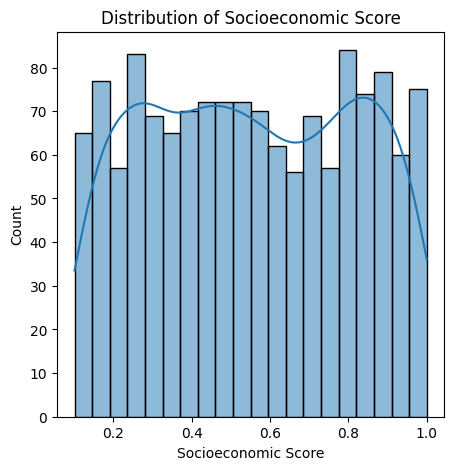

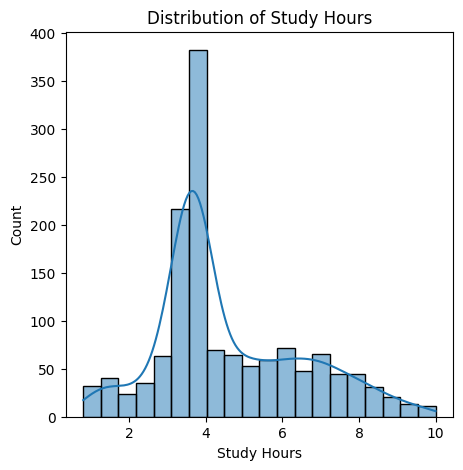

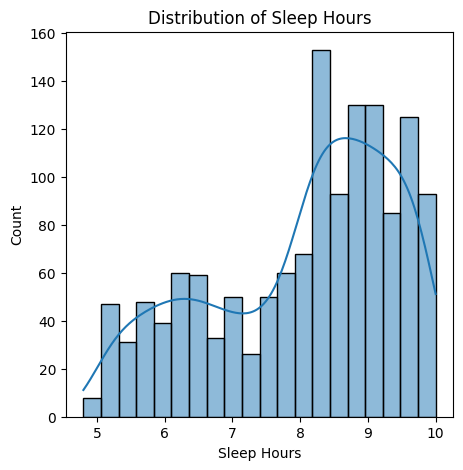

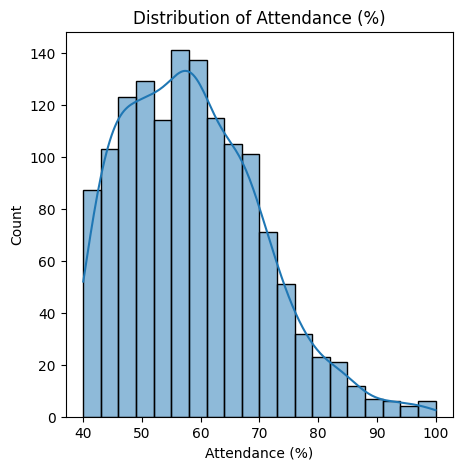

In [6]:
for i in range(df.columns.shape[0]-1):
    plt.figure(figsize=(5,5))
    column = df.columns[i]
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f"Distribution of {column}")
    plt.show()

Of course just seeing the distribution doesnt tell the whole story about the data, we need to dig a bit deeper by doing some multivariate analysis.

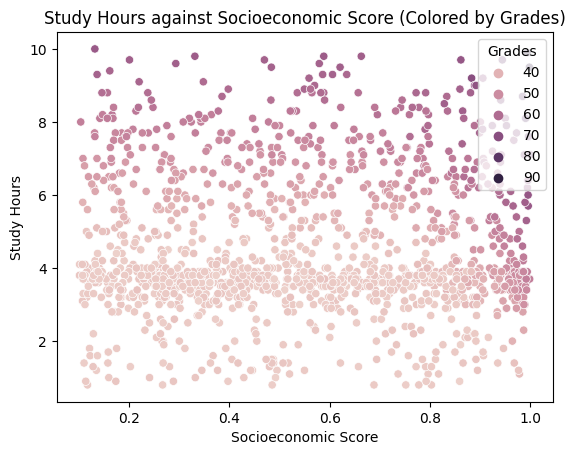

In [7]:
sns.scatterplot(df, x="Socioeconomic Score", y="Study Hours", hue="Grades")
plt.title("Study Hours against Socioeconomic Score (Colored by Grades)")
plt.show()

Seems interesting enough, we can see that socioeconomic doesnt really impact the students grade nor their study hours. But, the interesting part is that up until .8 to 1.0 of the socioeconomic score with the same study hours they can achieve a bit more then the lower counterpart. Let's keep on digging.

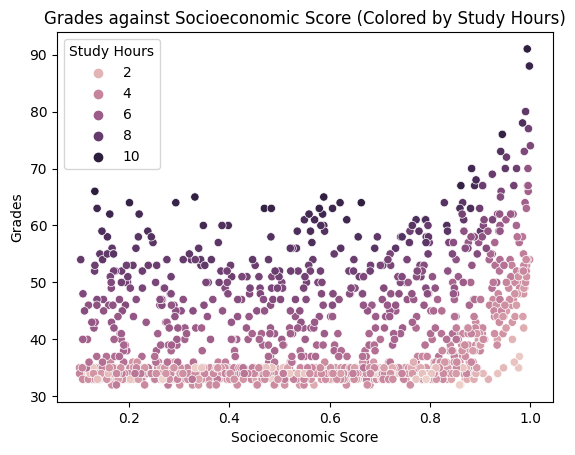

In [8]:
sns.scatterplot(df, x="Socioeconomic Score", y="Grades", hue="Study Hours")
plt.title("Grades against Socioeconomic Score (Colored by Study Hours)")
plt.show()

As expeted, the grades doesnt really improve much against the socioeconomic score, but that graphic really insinuate the point described before.

Lets switch gears to the attendance 

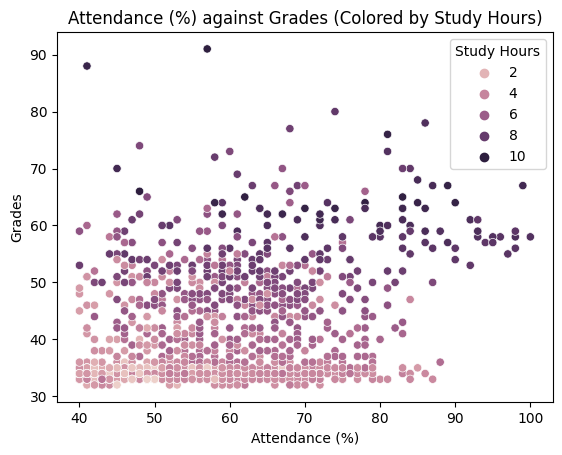

In [9]:
sns.scatterplot(df, x="Attendance (%)", y="Grades", hue="Study Hours")
plt.title("Attendance (%) against Grades (Colored by Study Hours)")
plt.show()

Now here we can see that above 90% of attendance student tend to have higher grades but at the same time their study hours not below 6 Hours, very diligent of student they are. So we can safely assume that the more attendance they have the more hours they spent for studying. How about their socioeconomic values

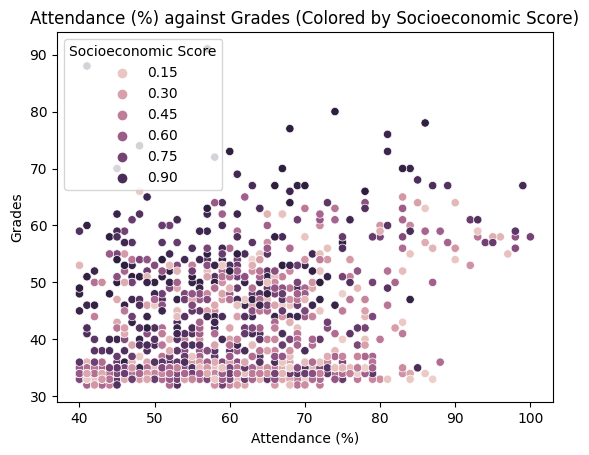

In [10]:
sns.scatterplot(df, x="Attendance (%)", y="Grades", hue="Socioeconomic Score")
plt.title("Attendance (%) against Grades (Colored by Socioeconomic Score)")
plt.show()

We cant really see pattern here, how about their sleep hours.

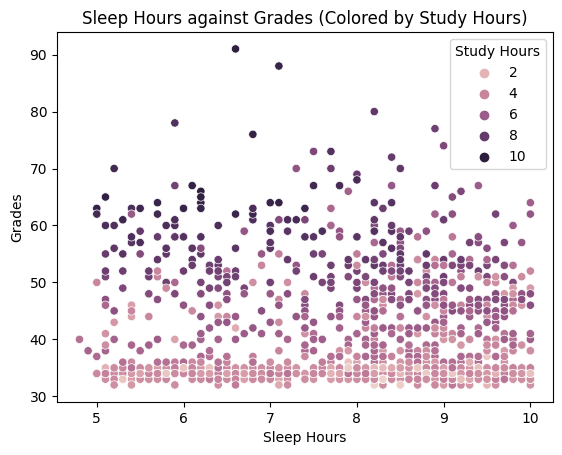

In [11]:
sns.scatterplot(df, x="Sleep Hours", y="Grades", hue="Study Hours")
plt.title("Sleep Hours against Grades (Colored by Study Hours)")
plt.show()

Well the more study hours the less their sleep hours are, but the one with 90 grade studied for about 9 hours with 7 hours sleep, seems like the optimal sweet spot for study duration / sleep hours. Well kids if you want to improve your grade study more and get well rested...

Moving on to their correlation value with each other, we can use the Pandas corr() method on a DataFrame object

<Axes: >

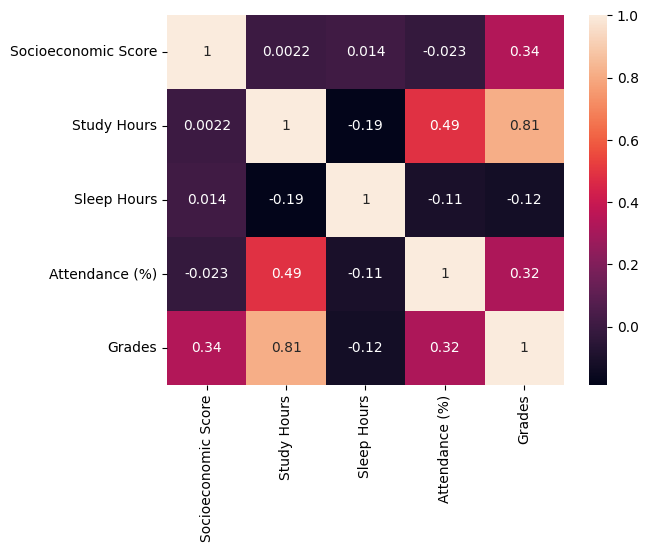

In [12]:
corr = df.corr()
sns.heatmap(corr, annot=True)

#### Socioeconomic Score
1. **Grades (0.34)**: There's a moderate positive correlation, suggesting students from higher socioeconomic backgrounds tend to have better grades. This could be due to factors like access to resources, support systems, or extracurricular activities.

2. **Study Hours (0.0022)**: The correlation is very weak, almost negligible, indicating socioeconomic status doesn't significantly impact the amount of time students spend studying.

3. **Sleep Hours (0.014)**: Similar to study hours, the very weak correlation indicates little impact of socioeconomic status on sleep duration.

4. **Attendance (-0.023)**: The negative correlation is very weak, showing that socioeconomic status doesn't have a significant impact on students' attendance.

#### Study Hours
1. **Grades (0.81)**: This strong positive correlation suggests that students who spend more time studying tend to achieve higher grades.

2. **Attendance (0.49)**: A moderate positive correlation indicates that students who study more are also likely to have better attendance. This could be due to a general sense of diligence and commitment to their education.

3. **Sleep Hours (-0.19)**: The weak negative correlation suggests that students who study more tend to sleep less, possibly because they are balancing their study hours with other activities.

#### Sleep Hours
1. **Attendance (-0.11)**: A weak negative correlation suggests that students who sleep more might attend fewer classes, though the effect is minor.

2. **Grades (-0.12)**: The weak negative correlation implies that more sleep does not necessarily correlate with higher grades. It's possible that students who sleep more are not spending as much time studying.

#### Attendance (%)
1. **Study Hours (0.49)**: The moderate positive correlation indicates that students who attend more classes are also likely to spend more time studying.

2. **Grades (0.32)**: This moderate positive correlation suggests that better attendance is associated with higher grades, likely because regular class attendance helps reinforce learning.

3. **Sleep Hours (-0.11)**: The weak negative correlation shows that higher attendance is slightly associated with less sleep, perhaps due to early morning classes or long school days.

#### Grades
1. **Study Hours (0.81)**: The strong positive correlation emphasizes the importance of study time in achieving good grades.
   
3. **Attendance (0.32)**: This moderate positive correlation reinforces the idea that regular class attendance benefits academic performance.
    
5. **Sleep Hours (-0.12)**: The weak negative correlation suggests that while sleep is important, excessive sleep might not directly correlate with better grades, especially if it cuts into study time.

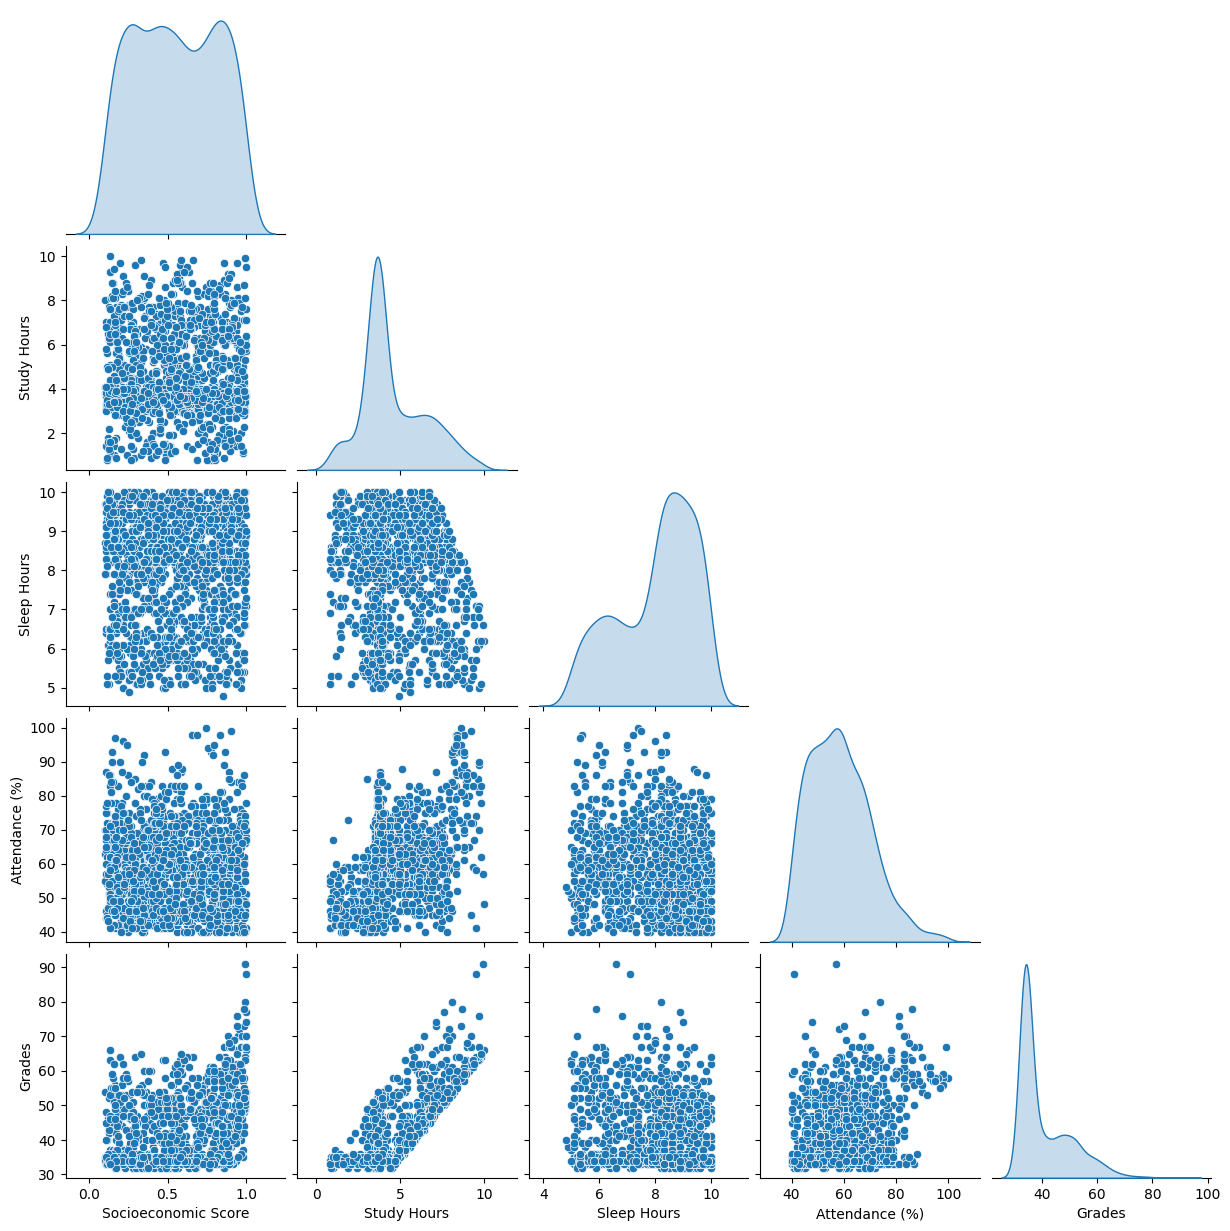

In [13]:
sns.pairplot(df, diag_kind='kde', corner=True)

As we can see that in the pariplot the study hours and grade is pretty much a linearly aligned. So the more you study, the more grade student got.

With that we can answer the side question that is :
>**Question**
>What metric impacted student performance the most?
>
>**Answer**
>The metric that have the most impact is the **Study Hours** because it aligns with the grade student got.

### Dataset Prep for Deep Neural Network
Prepping dataset for DNN is pretty straight forward, these are the steps :
1. First we split the dataset for training, validation, and testing
2. Then we split those dataset to ther respected features and labels, *TL:DR features are values used to generate labels, and labels are values we want to recreate*

After that we normally normalization using numpy or sklearn, instead we directly use the TensorFlow's Normalization Layer. So move on to model building

In [14]:
# Split the data into training, validation, and test
train_dataset, valtest_subset = train_test_split(df, test_size=0.2, random_state=1)
test_dataset, val_dataset = train_test_split(valtest_subset, test_size=0.5, random_state=1)

unsplit_features = df.copy().drop(["Grades"], axis=1)

In [15]:
# Splitting between Features and Targets
X_train = train_dataset.copy()
X_test = test_dataset.copy()
X_val = val_dataset.copy()

y_train = X_train.pop('Grades')
y_test = X_test.pop('Grades')
y_val = X_val.pop("Grades")

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Socioeconomic Score,0.553638,0.262847
Study Hours,4.570991,1.892610
Sleep Hours,8.045135,1.371377
Attendance (%),58.527027,11.602007
Grades,40.722523,9.344645


### Model Building
In this notebook, we aim to build models capable of predicting students' grades. Let's break down the steps involved:

**Defining Requirements:**

First, we need to establish the necessary components for our model.

**Data Normalization:**

Neural networks typically perform better when features are normalized. TensorFlow supports normalization directly within the layers, so we can integrate this step into our model.

**Creating Dense Layers:**

Next, we create Dense layers. These are fully connected layers where each neuron receives input from all the neurons in the previous layer. Here's where the term "neural network" comes into play. To introduce non-linearity, we use an activation function called ReLU (Rectified Linear Unit). The ReLU activation function helps the model learn more complex patterns by enabling non-linear transformations.

**Importance of ReLU:**

Without activation functions like ReLU, Dense layers would only perform linear transformations, essentially turning our neural network into a fancy version of Linear Regression. The introduction of ReLU allows the network to capture and learn intricate relationships within the data.



**Normalization Process:**

We start by normalizing the input features to ensure they are on a similar scale. This is done using the keras.layers.Normalization layer, which is fitted to the dataset. The mean of the normalized data is then printed to verify the normalization.



In [17]:
# Normalization using the keras.layers.Normalization to prep for DNN
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(unsplit_features))
print(normalizer.mean.numpy())

first = np.array(unsplit_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[ 0.5522  4.562   8.05   58.53  ]]
First example: [[ 0.96  3.4   8.2  53.  ]]

Normalized: [[ 1.55 -0.61  0.11 -0.47]]


In [18]:
# Helper Function for Plotting Loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Grades]')
  plt.legend()
  plt.grid(True)

**Model Definition and Compilation:**

The model is defined using the Sequential API. The architecture includes:

* The normalization layer.
* Two Dense layers with ReLU activation functions to introduce non-linearity.
* A final Dense layer with a single unit for the output, which predicts the students' grades.

In [19]:
# Model Definition
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(112, activation='relu'),
      layers.Dense(400, activation='relu'),
      layers.Dense(1)
  ])
  return model

**Early Stopping:**

To prevent overfitting, we implement early stopping. This technique monitors the validation accuracy and stops the training if it does not improve for a specified number of epochs (patience). Additionally, it restores the best weights obtained during training.

**Learning Rate Scheduler:**

A learning rate scheduler adjusts the learning rate during training. Here, we define a step decay function that reduces the learning rate by a factor of 0.65 every 15 epochs.

In [20]:
# Early stopping Implementation for high number of Epoch Training to prevent Overfitting
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.01,
    mode='max',
    restore_best_weights=True)


# Define the step learning rate scheduler function
def step_decay(epoch, lr):
    drop = 0.65
    epochs_drop = 15
    if epoch % epochs_drop == 0 and epoch:
        return lr * drop
    return lr

# LR Scheduler implementation using keras callbacks
scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

# LR value, FCN Unit number, and Optimizer are result of Keras Tuner Session from 100 trial run
model = build_and_compile_model(normalizer)
model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.SGD(0.004798482863954841),
                metrics = ['mean_absolute_error'])

The values for Learning Rate, FCN (Fully Connected Network) Unit numbers, and Optimizer are the results of a Keras Tuner session conducted over 100 trial runs. This tuning process helps identify the optimal hyperparameters for our model, ensuring it achieves the best possible performance.

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (1388, 4)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (40.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9 (40.00 B)

### Model Training
Since we've already implemented a Learning Rate Scheduler and Early Stopping, we can confidently set a higher number of epochs without worrying about overfitting. These techniques help ensure that the model training process is efficient and effective.

**Early Stopping:**

This technique monitors the validation accuracy and halts training when it stops improving for a specified number of epochs. By restoring the best weights obtained during training, we avoid overfitting and ensure optimal model performance.

**Learning Rate Scheduler:** 

The learning rate scheduler adjusts the learning rate during training. Our step decay function reduces the learning rate by a factor of 0.65 every 15 epochs. This helps the model converge more efficiently by gradually decreasing the learning rate, allowing for finer adjustments during the later stages of training.

In [22]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[scheduler, stop])

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1082.5671 - mean_absolute_error: 28.8696 - val_loss: 17.8221 - val_mean_absolute_error: 3.3986 - learning_rate: 0.0048
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.1298 - mean_absolute_error: 6.4127 - val_loss: 68.2899 - val_mean_absolute_error: 6.7466 - learning_rate: 0.0048
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.7885 - mean_absolute_error: 4.8184 - val_loss: 7.0393 - val_mean_absolute_error: 2.0321 - learning_rate: 0.0048
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9600 - mean_absolute_error: 2.1506 - val_loss: 4.6367 - val_mean_absolute_error: 1.6412 - learning_rate: 0.0048
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9488 - mean_absolute_error: 2.2411 - val_loss: 20.0608 - val_mean_absolute_error: 3.9465 - learning_rate: 0.0048
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.8103 - mean_absolute_error: 3.1720 - val_loss: 6.4836 - val_mean_abso

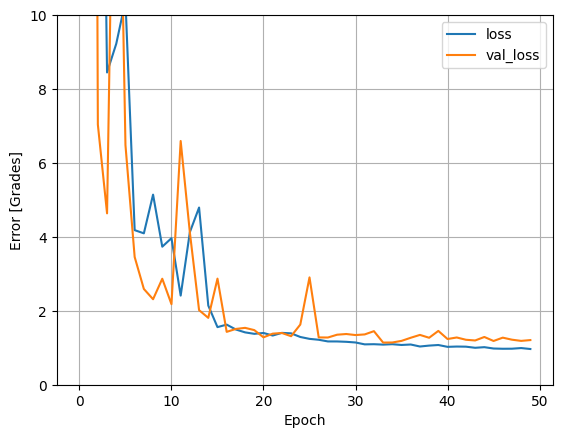

In [23]:
plot_loss(history)

### Model Testing
After training our model, it's crucial to test its performance on unseen data to ensure it generalizes well. This process involves making predictions on the test dataset and evaluating the results.

**Making Predictions:**

We use the trained model to predict the outcomes for the test dataset (X_test). The predictions are stored in the variable yhat.

In [24]:
yhat = model.predict(X_test)
yhat.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


(139, 1)

**Explanation:**

**Model Predictions:**

We use the **model.predict()** function to generate predictions (yhat) for the test dataset (X_test). This function applies the trained model to the test data and outputs the predicted values.

**Shape Verification:**

By checking the shape of yhat, we confirm that the number of predictions matches the number of samples in X_test. This step ensures consistency and helps verify that our predictions are correctly formatted.

#### Evaluation Metrics
This code uses various evaluation metrics from the sklearn.metrics library to measure the accuracy of your model's predictions.

1. **Mean Absolute Error (MAE)**:

* This metric measures the average absolute difference between the predicted values (yhat) and the actual values (y_test).

* A lower MAE value indicates better model performance.

2. **Mean Squared Error (MSE)**:

* This metric calculates the average squared difference between the predicted values and the actual values.

* A lower MSE value indicates better model performance. Unlike MAE, MSE gives a higher penalty to larger errors.

3. **Root Mean Squared Error (RMSE)**:

* This is the square root of the MSE, providing a measure of the average error in the same units as the target variable.

* RMSE is more interpretable than MSE because it is in the same unit as the predicted values.

4. **Recall**:

* Recall (or Sensitivity) measures the proportion of actual positive cases that were correctly identified by the model.

* In this context, it is calculated for multi-class classification with average='macro', giving equal weight to each class.

* zero_division=0 parameter ensures that in case of a division by zero, the score is set to zero.

5. **F1 Score**:

* The F1 Score is the harmonic mean of Precision and Recall, providing a balance between the two.

* It is also calculated for multi-class classification with average='macro', giving equal weight to each class.

* zero_division=0 parameter ensures that in case of a division by zero, the score is set to zero.

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, f1_score, confusion_matrix
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_test, yhat)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, yhat)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Recall
recall = recall_score(y_test, yhat.round(), average='macro', zero_division=0)
print(f"Recall: {recall}")

# Calculate F1 Score
f1 = f1_score(y_test, yhat.round(), average='macro', zero_division=0)
print(f"F1 Score: {f1}")


Mean Absolute Error (MAE): 0.814523381294964
Mean Squared Error (MSE): 1.08380873426259
Root Mean Squared Error (RMSE): 1.0410613499033523
Recall: 0.2434817563388992
F1 Score: 0.22843044646279145


**Mean Absolute Error (MAE)**

MAE: 0.7994604316546763
* This metric measures the average absolute difference between the predicted values and the actual values.
* On average, the model's predictions are off by about 0.8 units from the actual values.
* Lower values indicate better performance, so this is a relatively moderate error.

**Mean Squared Error (MSE)**

MSE: 1.0555727293165467

* MSE calculates the average squared difference between the predicted values and the actual values.
* It penalizes larger errors more heavily due to the squaring of differences.
* An MSE of around 1.06 suggests there are some larger errors in the predictions.

**Root Mean Squared Error (RMSE)**

RMSE: 1.0274106916499102
* RMSE is the square root of MSE, providing an error measure in the same units as the target variable.
* An RMSE of approximately 1.03 indicates the average error is slightly over 1 unit, which gives a clearer sense of the prediction accuracy in the context of the target variable's scale.

**Recall**

* Recall: 0.19416202844774275
* Recall measures the proportion of actual positive cases correctly identified by the model. 
* With a value of approximately 0.19, the model has a low recall, indicating it misses a significant number of positive cases.

**F1 Score**

F1 Score: 0.1659719116861974

* The F1 Score is the harmonic mean of Precision and Recall, providing a balance between the two.
* An F1 Score of around 0.17 suggests that the model struggles to achieve a good balance between correctly predicting positive cases and avoiding false positives.

### Summary
MAE and RMSE suggest moderate prediction accuracy with an average error slightly over 1 unit.

MSE indicates that there are some larger errors present.

Recall and F1 Score show that the model has difficulty identifying positive cases and balancing precision and recall, leading to lower performance in these metrics.

Below are codes for displaying the sample of prediction and the actual target from the dataset

In [26]:
yhat[:10]

array([[34.06],
       [49.72],
       [34.  ],
       [33.75],
       [33.94],
       [35.3 ],
       [33.5 ],
       [44.84],
       [39.22],
       [33.84]], dtype=float16)

In [27]:
y_test[:10]

27      34.0
487     49.0
679     33.0
1138    35.0
1181    34.0
120     36.0
821     34.0
1320    46.0
708     39.0
673     34.0
Name: Grades, dtype: float64

**Purpose**
The purpose of these lines of code is to print and compare the first 10 actual values (y_test) with the first 10 predicted values (yhat). This can help you quickly inspect and visually assess the accuracy of the model's predictions on a small subset of the test data.

**Why It's Useful**
Visual Inspection: By looking at these values side-by-side, you can get an immediate sense of how well the model's predictions align with the actual values.

**Debugging and Analysis**: 
If there are significant discrepancies, you might investigate further to understand where and why the model is making errors.

**Quick Check**: This quick check can be especially useful in an iterative development process, helping you make rapid assessments before diving into more detailed evaluation metrics.